# Exercise 1: Warming Up
In this first exercise I trained a *small* autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri.

#### Colab Setup

In [3]:
#if using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets wandb torchmetrics

#### Basic Imports

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

#### Dante Generator

In [ ]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('/content/drive/MyDrive/LaboratoryDLA/LAB2/dante.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

#### The model

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
      # idx is (B, T) array of indices in the current context
      for _ in range(max_new_tokens):
          # crop idx to the last block_size tokens
          idx_cond = idx[:, -block_size:]
          # get the predictions
          logits, loss = self(idx_cond)
          # focus only on the last time step
          logits = logits[:, -1, :] # becomes (B, C)
          # apply softmax to get probabilities
          probs = F.softmax(logits, dim=-1) # (B, C)
          # sample from the distribution
          idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
          # append sampled index to the running sequence
          idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
      return idx

####Training loop

In [ ]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10.783546 M parameters
step 0: train loss 4.0481, val loss 4.0425
step 500: train loss 1.7516, val loss 1.8010
step 1000: train loss 1.2666, val loss 1.5518
step 1500: train loss 0.7492, val loss 1.6696
step 2000: train loss 0.2980, val loss 2.1068
step 2500: train loss 0.1388, val loss 2.5982
step 3000: train loss 0.0991, val loss 2.9071
step 3500: train loss 0.0872, val loss 3.1320
step 4000: train loss 0.0803, val loss 3.3237
step 4500: train loss 0.0779, val loss 3.3884
step 5000: train loss 0.0731, val loss 3.4739
step 5500: train loss 0.0697, val loss 3.5807
step 6000: train loss 0.0673, val loss 3.6510
step 6500: train loss 0.0654, val loss 3.7594
step 7000: train loss 0.0642, val loss 3.8150
step 7500: train loss 0.0628, val loss 3.8619
step 8000: train loss 0.0615, val loss 3.9680
step 8500: train loss 0.0606, val loss 3.9595
step 9000: train loss 0.0594, val loss 3.9947
step 9500: train loss 0.0595, val loss 4.0293
step 9999: train loss 0.0582, val loss 4.0792

udir: <<Perche

The model seems to be overfitted since the validation loss increases but the generated text looks ok.

# Exercise 2: Working with Real LLMs

In this exercise I used the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a *huge* variety of pre-trained transformer models.

## Exercise 2.1: Installation and text tokenization

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.


In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
text = "Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura che' la diritta via era smarrita."

tokenized_text = tokenizer.encode(text, return_tensors="pt")
print(f"Text length {len(text)}, tokenized length {len(tokenized_text[0])}")

**Results:**
```
Text length 102, tokenized length 38
```



## Exercise 2.2: Generating Text

Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

class Prompt_Generator:
    def __init__(self, config):
        self.tokenizer = GPT2Tokenizer.from_pretrained(config["Tokenizer"])
        self.model = GPT2LMHeadModel.from_pretrained(config["Model"])
        self.do_sample = config["do_sample"]
        self.temperature = config["temperature"]
        self.max_lenght = config["max_lenght"]
        self.no_repeat_ngram_size = config["no_repeat_ngram_size"]
        self.prompt = config.get("prompt")

    def generate(self, prompt = None, do_sample = None, temperature = None, max_lenght = None, no_repeat_ngram_size = None):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        if prompt is not None:
          self.prompt = prompt
        if temperature is not None:
          self.temperature = temperature
        if do_sample is not None:
          self.do_sample = do_sample
        if max_lenght is not None:
          self.max_lenght = max_lenght
        if no_repeat_ngram_size is not None:
          self.no_repeat_ngram_size = no_repeat_ngram_size
        tokenized_output = self.model.generate(**inputs,
                                  max_new_tokens = self.max_lenght,
                                  no_repeat_ngram_size = self.no_repeat_ngram_size,
                                  temperature = self.temperature,
                                  do_sample = self.do_sample,
                                  pad_token_id = self.tokenizer.eos_token_id)
        output = self.tokenizer.decode(tokenized_output[0], skip_special_tokens=True)
        print(output)


#### Some trials with different parameters

In [ ]:
config = {"Tokenizer": "openai-community/gpt2",
        "Model": "openai-community/gpt2",
        "do_sample": True,
        "temperature": 2.0,
        "max_lenght": 30,
        "no_repeat_ngram_size": 2,
        }

prompt_generator = Prompt_Generator(config)
prompt_generator.generate("What are")
prompt_generator.generate("I am")
prompt_generator.generate("You")

What are you supposed to say if it doesn't happen… that it happened? Well that means to give your team the winning hand that got them down against an
I am sorry - what were your worries before? I have learned not you - but what have yours - like I was? That, ahah? Oh...
You like them. The one who came down under from this is really very attractive," Bitt said, referring to the Trump who won with fewer supporters than


In [ ]:
prompt_generator.generate("What are", do_sample=False)
prompt_generator.generate("I am")
prompt_generator.generate("You")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `2.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


What are the best ways to get your hands on a new game?

We've got a lot of great games coming out this year, and we're
I am not a fan of the idea of a "big-budget" movie. I think it's a waste of money.

I think the movie
You, the man who has been the most important person in my life, I am sorry for what I have done. I will never forget that day.


In [ ]:
prompt_generator.generate("What are", do_sample=True, temperature= 9.0)
prompt_generator.generate("I am")
prompt_generator.generate("You")

What are YOU watching next (not on CBS right where We've never heard on that) CBS SundayNight's Jon Belgrade chats politics (@SandyStrick
I am looking across both systems again... "A: Okay for any further question." ―Thon Tse'nin and Lor Rond with Hao J
You "must always carry something. And be as free not averse..." - Michael Carusoglu In order unto men of virtue to fulfill those qualities to


*Raising the **temperature** makes the generation pretty bad.*

In [ ]:
prompt_generator.generate("What are", do_sample=True, temperature= 2.0, no_repeat_ngram_size=5)
prompt_generator.generate("I am")
prompt_generator.generate("You")

What are Your thoughts about this case?

Your favorite news outlets make each of their headlines based entirely on what stories they want (see newsrooms from your
I am afraid we all learn very soon from childhood how quickly we have come into contact between man the thing to worry about the little one to whom to relate.
You to try?

Have something specific to offer? Email: askalev.bazakh < AskAriV@google.com> or


In [ ]:
prompt_generator.generate("What are", do_sample=True, temperature= 2.0, no_repeat_ngram_size=9)
prompt_generator.generate("I am")
prompt_generator.generate("You")

What are the latest tech and games release trends across every game category to know about and try to forecast next year? Who did the best debut last month under "
I am truly humbled to be speaking up and making sure every single mother's son receives a clean, honest medical treatment that respects a fetus from her or her
You a liar?" my mother asked with wide eyes and no remorse? We laughed like little boys! And who among us looked shocked when I got back to


*Also raising the **no_repeat_ngram_size** too much makes the generation a little less natural.*

# Exercise 3.1: Training a Text Classifier

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.



#### Model Definition

In [2]:
from transformers import DistilBertTokenizer, DistilBertModel, set_seed
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.nn import functional as F

class TextClassifier(nn.Module):
    def __init__(self, num_classes = 2):
        super(TextClassifier, self).__init__()
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, text,attention_mask, device):
        #inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = text.to(device)
        output = self.backbone(inputs, attention_mask = attention_mask)
        cls_token = output['last_hidden_state'][:, 0, :]
        return self.head(cls_token)

#### LLM Trainer Definition inspired by the one in LAB1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchmetrics
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, load_metric
from tqdm import tqdm
import os

class LLMTrainer:
    def __init__(self, config):

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epochs = config["num_epochs"]
        self.batch_size = config.get("batch_size", 16)
        self.learning_rate = config.get("learning_rate", 5e-5)
        self.model_name = config["model_name"]

        if config["use_wandb"]:
            self.use_wandb = True
            wandb.init(project="TextClassification", config=config)
        else:
            self.use_wandb = False

        #self.tokenizer = AutoTokenizer.from_pretrained(self.pretrained)
        #self.model = AutoModelForSequenceClassification.from_pretrained(self.pretrained, num_labels=int(config["num_classes"]))
        match self.model_name:
            case "text_classifier":
                self.model = TextClassifier(num_classes=int(config["num_classes"]))
                self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
                self.backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")

        self.model.to(self.device)


        # Dataset loading
        dataset_name = config["dataset"]
        self.dataset = load_dataset(dataset_name)

        # Tokenize datasets
        self.train_dataset = self.dataset['train'].map(self.tokenize_function, batched=True)
        if 'validation' in self.dataset:
            self.val_dataset = self.dataset['validation'].map(self.tokenize_function, batched=True)
        else:
            # Create validation split from training data
            val_size = int(0.2 * len(self.train_dataset))
            train_size = len(self.train_dataset) - val_size
            self.train_dataset, self.val_dataset = random_split(self.train_dataset, [train_size, val_size])

        self.test_dataset = self.dataset['test'].map(self.tokenize_function, batched=True)

        self.train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        self.val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        self.test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

        self.training_mode = config["training_mode"]
        print(self.training_mode)
        if self.training_mode == "finetune":
            backbone_params = list(self.model.backbone.parameters())
            head_params = list(self.model.head.parameters())
            lrs = [
                  {'params': backbone_params, 'lr': config["lr"]/1e2},
                  {'params': head_params, 'lr': config["lr"]}
            ]
        elif self.training_mode == "head_only":
            lrs = [
                  {'params': self.model.head.parameters(), 'lr': config["lr"]}
            ]
            for param in self.model.backbone.parameters():
                  param.requires_grad = False
        else:
            lrs = [
                  {'params': self.model.parameters(), 'lr': config["lr"]}
            ]
        match config["optimizer"]:
            case "adam":
                self.optimizer = optim.Adam(lrs)
            case "sgd":
                self.optimizer = optim.SGD(lrs)
            case "adamw":
                self.optimizer = optim.AdamW(lrs)
            case _:
                raise ValueError(f'Optimizer not found. Received {config["optimizer"]}.')

        match config["loss"]:
            case "cross_entropy":
                self.loss = nn.CrossEntropyLoss()
            case _:
                raise ValueError(f'Loss not found. Received {config["loss"]}.')

        self.metrics = []
        for metric in config["metrics"]:
            match metric:
                case "accuracy":
                    self.metrics.append(torchmetrics.Accuracy(task="multiclass", num_classes=config["num_classes"]).to(self.device))
                case "precision":
                    self.metrics.append(torchmetrics.Precision(task="multiclass", average='macro', num_classes=config["num_classes"]).to(self.device))
                case "recall":
                    self.metrics.append(torchmetrics.Recall(task="multiclass", average='macro', num_classes=config["num_classes"]).to(self.device))
                case _:
                    raise ValueError(f'Metric not found. Received {metric}.')

    def tokenize_function(self, examples):
        return self.tokenizer(examples['text'], padding="max_length", truncation=True)

    def train_head(self, epochs=10, lr=3e-4):
        self.model.train()
        optimizer = torch.optim.AdamW(self.model.head.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            acc_loss = 0
            for i, batch in tqdm(enumerate(self.train_loader)):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask)
                loss = self.loss(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                acc_loss += loss.item()
                if (i + 1) % 500 == 0:
                    if self.use_wandb:
                        wandb.log({"loss": acc_loss / 500})
                    print(f"Epoch {epoch}, batch {i}, loss {acc_loss / 500}")
                    acc_loss = 0

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0

        for batch in tqdm(self.train_loader):
            #print(batch)  # Print batch for debugging

            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["label"].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask=attention_mask, device = self.device)
            loss = self.loss(outputs, labels)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(self.train_loader)
        print(f"Training Loss: {train_loss:.4f}")

    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in self.val_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask, device=self.device)
                loss = self.loss(outputs, labels)

                val_loss += loss.item()
                all_preds.append(outputs.argmax(dim=-1))
                all_labels.append(labels)

        val_loss /= len(self.val_loader)
        val_preds = torch.cat(all_preds)
        val_labels = torch.cat(all_labels)

        metrics = {metric.__class__.__name__: metric(val_preds, val_labels) for metric in self.metrics}

        if self.use_wandb:
            wandb.log({"val_loss": val_loss, **metrics})

        print(f'Validation Loss: {val_loss:.4f}')
        for name, value in metrics.items():
            print(f'Validation {name}: {value:.4f}')


    def test(self):
        self.model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask, device=self.device)
                loss = self.loss(outputs, labels)
                test_loss += loss.item()
                all_preds.append(outputs.argmax(dim=-1))
                all_labels.append(labels)

        test_loss /= len(self.test_loader)
        test_preds = torch.cat(all_preds)
        test_labels = torch.cat(all_labels)

        metrics = {metric.__class__.__name__: metric(test_preds, test_labels) for metric in self.metrics}

        if self.use_wandb:
            wandb.log({"test_loss": test_loss, **metrics})

        print(f'Test Loss: {test_loss:.4f}')
        for name, value in metrics.items():
            print(f'Test {name}: {value:.4f}')



    def test_and_print(self, num_prints=20):
        self.model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        all_inputs = []
        all_attention_masks = []
        i = 0

        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask, device=self.device)
                loss = self.loss(outputs, labels)
                test_loss += loss.item()
                all_preds.append(outputs.argmax(dim=-1).cpu())
                all_labels.append(labels.cpu())
                all_inputs.append(input_ids.cpu())
                all_attention_masks.append(attention_mask.cpu())
                if i > num_prints:
                    break
                i += 16

        for pred, label, input_id, attention_mask in zip(all_preds, all_labels, all_inputs, all_attention_masks):
            for p, l, ids, mask in zip(pred, label, input_id, attention_mask):
                tokens = ids[mask == 1].tolist()  # Only consider tokens where the attention mask is 1
                decoded_input = self.tokenizer.decode(tokens, skip_special_tokens=True)
                print(f"Input: {decoded_input}")
                print(f"Prediction: {self.decode_emotion(p.item())}")
                print(f"Label: {self.decode_emotion(l.item())}")
                print("-" * 50)

    def decode_emotion(self, i):
        match i:
          case 0:
            return "Sadness"
          case 1:
            return "Joy"
          case 2:
            return "Love"
          case 3:
            return "Anger"
          case 4:
            return "Fear"
          case 5:
            return "Surprise"
          case _:
            raise ValueError(f'Emotion not found. Received {i}.')


    def run(self):
        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch + 1}/{self.num_epochs}')
            self.train_one_epoch()
            self.evaluate()
        self.test()
        self.test_and_print()
        if self.use_wandb:
            wandb.finish()


#### Classification Head Shallow Training

In [ ]:
config = {
    "use_wandb": True,
    "num_epochs": 10,
    "model_name": "text_classifier",
    "dataset": "dair-ai/emotion",
    "batch_size": 16,
    "lr": 5e-5,
    "num_classes": 6,
    "metrics": ["accuracy", "precision", "recall"],
    "optimizer": "adamw",
    "loss": "cross_entropy",
    "training_mode": "head_only"
}

trainer = LLMTrainer(config)
trainer.run()

#### Quantitative Evaluation

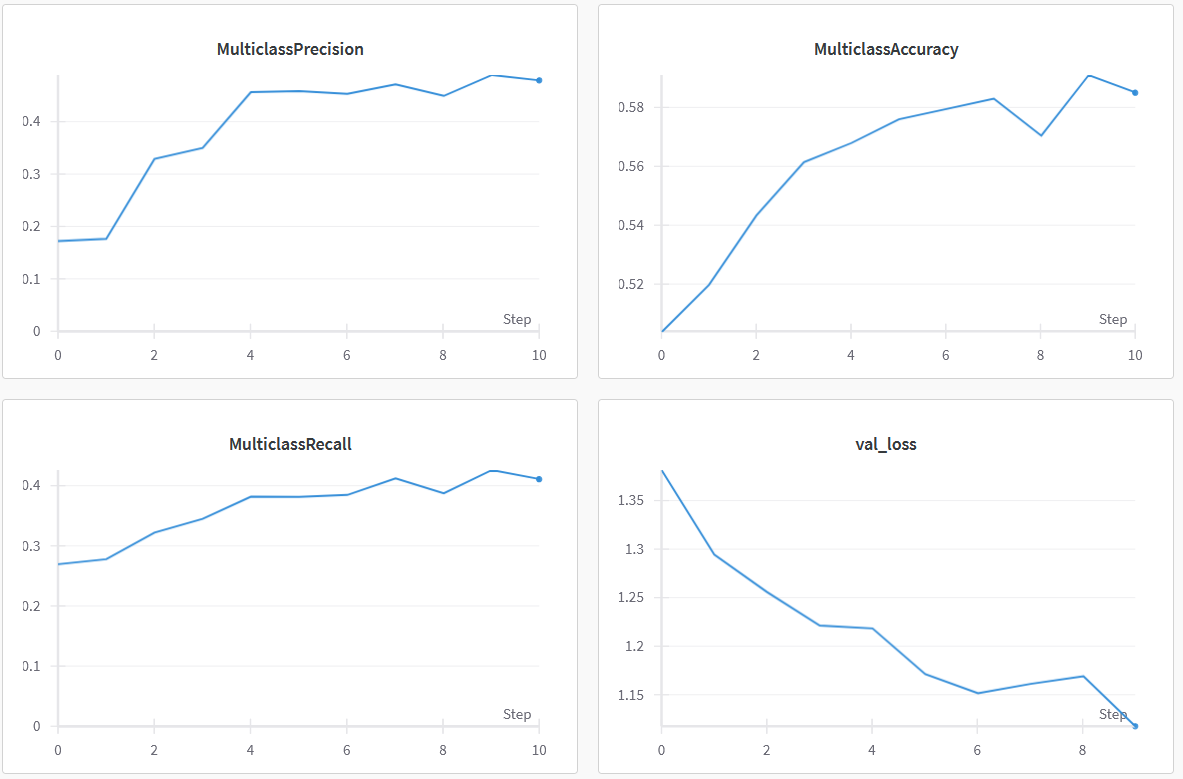

**Run Summary:** \
Test Loss: **1.1042** \
Test MulticlassAccuracy: **0.5850** \
Test MulticlassPrecision: **0.4788** \
Test MulticlassRecall: **0.4108**

#### Qualitative Evaluation
The model learned something since it is doing a almost 60% accuracy on a 6-class dataset but it probaby could do better.



```
Input: im feeling rather rotten so im not very ambitious right now
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: im updating my blog because i feel shitty
Prediction: Anger
Label: Sadness
--------------------------------------------------
Input: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i was feeling a little vain when i did this one
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i cant walk into a shop anywhere where i do not feel uncomfortable
Prediction: Joy
Label: Fear
--------------------------------------------------
Input: i felt anger when at the end of a telephone call
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i like to have the same breathless feeling as a reader eager to see what will happen next
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer
Prediction: Sadness
Label: Anger
--------------------------------------------------
Input: i don t feel particularly agitated
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey
Prediction: Love
Label: Sadness
--------------------------------------------------
Input: i pay attention it deepens into a feeling of being invaded and helpless
Prediction: Anger
Label: Fear
--------------------------------------------------
Input: i just feel extremely comfortable with the group of people that i dont even need to hide myself
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i find myself in the odd position of feeling supportive of
Prediction: Fear
Label: Love
--------------------------------------------------
Input: i was feeling as heartbroken as im sure katniss was
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel a little mellow today
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel like my only role now would be to tear your sails with my pessimism and discontent
Prediction: Anger
Label: Sadness
--------------------------------------------------
Input: i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight
Prediction: Joy
Label: Anger
--------------------------------------------------
Input: i feel like reds and purples are just so rich and kind of perfect
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i survey my own posts over the last few years and only feel pleased with vague snippets of a few of them only feel that little bits of them capture what its like to be me or someone like me in dublin in the st century
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i also tell you in hopes that anyone who is still feeling stigmatized or ashamed of their mental health issues will let go of the stigma let go of the shame
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i don t feel guilty like i m not going to be able to cook for him
Prediction: Joy
Label: Sadness
--------------------------------------------------
Input: i hate it when i feel fearful for absolutely no reason
Prediction: Anger
Label: Fear
--------------------------------------------------
Input: i am feeling outraged it shows everywhere
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i stole a book from one of my all time favorite authors and now i feel like a rotten person
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i do feel insecure sometimes but who doesnt
Prediction: Sadness
Label: Fear
--------------------------------------------------
Input: i highly recommend visiting on a wednesday if youre able because its less crowded so you get to ask the farmers more questions without feeling rude for holding up a line
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: ive been missing him and feeling so restless at home thinking of him
Prediction: Sadness
Label: Fear
--------------------------------------------------
Input: i posted on my facebook page earlier this week ive been feeling a little grumpy and out of sorts the past few days
Prediction: Sadness
Label: Anger
--------------------------------------------------
Input: i start to feel emotional
Prediction: Fear
Label: Sadness
--------------------------------------------------
Input: i feel so cold a href http irish
Prediction: Sadness
Label: Anger
--------------------------------------------------
Input: i feel like i m defective or something for not having baby fever
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel more virtuous than when i eat veggies dipped in hummus
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of you read magazines concerned with health and clean lifestyles such as the green parent
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i spent the last two weeks of school feeling miserable
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: im feeling very peaceful about our wedding again now after having
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i had been talking to coach claudia barcomb and coach ali boe for a long time and they both made me feel very welcomed at union
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change
Prediction: Joy
Label: Anger
--------------------------------------------------
Input: i feel humiliated embarrassed or foolish i will remember that others have felt the same way because of the same kinds of things and i will be kind and helpful and accepting
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel reassured that i am dealing with my diet in the right way and that all is good
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel i have to agree with her even though i can imagine some rather unpleasant possible cases
Prediction: Fear
Label: Sadness
--------------------------------------------------
Input: im in such a happy mood today i feel almost delighted and i havent done anything different today then i normally have it is wonderful
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: im feeling really out of place and irritated
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i also know that i feel nothing than a friendly affection to them too
Prediction: Love
Label: Joy
--------------------------------------------------
Input: i feel like i had a rather productive weekend and i cant always say that no matter how much i get done
Prediction: Joy
Label: Joy
--------------------------------------------------```



#### Finetune the Whole Model
To increase the performances I tried to finetune the whole model:

In [ ]:
config = {
    "use_wandb": True,
    "num_epochs": 10,
    "model_name": "text_classifier",
    "dataset": "dair-ai/emotion",
    "batch_size": 16,
    "lr": 5e-5,
    "num_classes": 6,
    "metrics": ["accuracy", "precision", "recall"],
    "optimizer": "adamw",
    "loss": "cross_entropy",
    "training_mode": "finetune"
}

trainer = LLMTrainer(config)
trainer.run()

#### Quantitative Evalutation:
The model have great performances with more than 90% accuracy.\
It is not overfitted as shown by the plot of the val_loss.

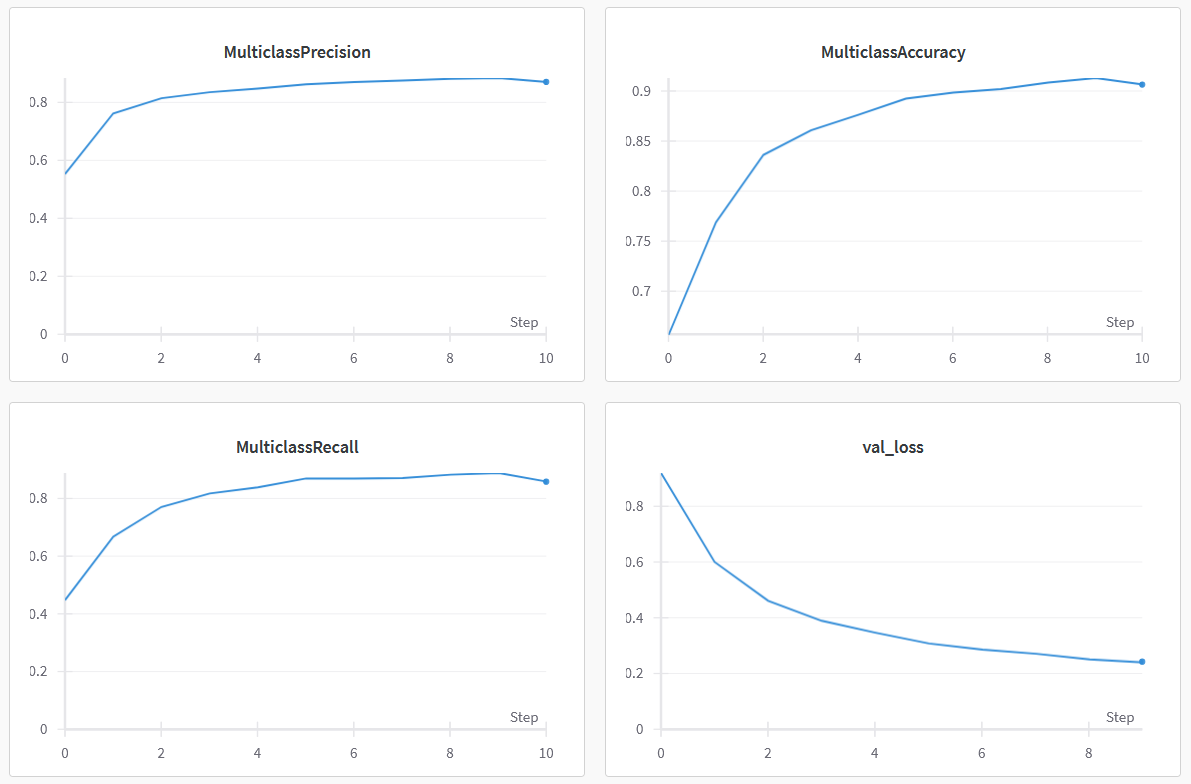

**Run Summary**\
Test Loss: **0.2398**\
Test MulticlassAccuracy: **0.9065**\
Test MulticlassPrecision: **0.8704**\
Test MulticlassRecall: **0.8581**

#### Qualitative Evalutation

Also qualitatively now predictions make way more sense than the shallow model.



```
Input: im feeling rather rotten so im not very ambitious right now
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: im updating my blog because i feel shitty
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i was feeling a little vain when i did this one
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i cant walk into a shop anywhere where i do not feel uncomfortable
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i felt anger when at the end of a telephone call
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia
Prediction: Sadness
Label: Joy
--------------------------------------------------
Input: i like to have the same breathless feeling as a reader eager to see what will happen next
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i don t feel particularly agitated
Prediction: Anger
Label: Fear
--------------------------------------------------
Input: i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i pay attention it deepens into a feeling of being invaded and helpless
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i just feel extremely comfortable with the group of people that i dont even need to hide myself
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i find myself in the odd position of feeling supportive of
Prediction: Love
Label: Love
--------------------------------------------------
Input: i was feeling as heartbroken as im sure katniss was
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel a little mellow today
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel like my only role now would be to tear your sails with my pessimism and discontent
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i feel like reds and purples are just so rich and kind of perfect
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years
Prediction: Love
Label: Sadness
--------------------------------------------------
Input: i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i survey my own posts over the last few years and only feel pleased with vague snippets of a few of them only feel that little bits of them capture what its like to be me or someone like me in dublin in the st century
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i also tell you in hopes that anyone who is still feeling stigmatized or ashamed of their mental health issues will let go of the stigma let go of the shame
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i don t feel guilty like i m not going to be able to cook for him
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i hate it when i feel fearful for absolutely no reason
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i am feeling outraged it shows everywhere
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i stole a book from one of my all time favorite authors and now i feel like a rotten person
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i do feel insecure sometimes but who doesnt
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i highly recommend visiting on a wednesday if youre able because its less crowded so you get to ask the farmers more questions without feeling rude for holding up a line
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: ive been missing him and feeling so restless at home thinking of him
Prediction: Fear
Label: Fear
--------------------------------------------------
Input: i posted on my facebook page earlier this week ive been feeling a little grumpy and out of sorts the past few days
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i start to feel emotional
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel so cold a href http irish
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i feel like i m defective or something for not having baby fever
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel more virtuous than when i eat veggies dipped in hummus
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of you read magazines concerned with health and clean lifestyles such as the green parent
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i spent the last two weeks of school feeling miserable
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: im feeling very peaceful about our wedding again now after having
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i had been talking to coach claudia barcomb and coach ali boe for a long time and they both made me feel very welcomed at union
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i feel humiliated embarrassed or foolish i will remember that others have felt the same way because of the same kinds of things and i will be kind and helpful and accepting
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: i feel reassured that i am dealing with my diet in the right way and that all is good
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel i have to agree with her even though i can imagine some rather unpleasant possible cases
Prediction: Sadness
Label: Sadness
--------------------------------------------------
Input: im in such a happy mood today i feel almost delighted and i havent done anything different today then i normally have it is wonderful
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: im feeling really out of place and irritated
Prediction: Anger
Label: Anger
--------------------------------------------------
Input: i also know that i feel nothing than a friendly affection to them too
Prediction: Joy
Label: Joy
--------------------------------------------------
Input: i feel like i had a rather productive weekend and i cant always say that no matter how much i get done
Prediction: Joy
Label: Joy
--------------------------------------------------```

